# 🎂 Segmind Challenge : Prediction of Sales of each Store🎂

## TO DO:

> Predict store sales of a store using the given dataset.

## Data:
> Dataset Given

* The dataset consists of 4 CSV files:
* TRAIN.csv : (./dataset/TRAIN.csv)
* TEST.csv: (./dataset/TEST.csv)
* store.csv - additional information regarding the stores: (./dataset/store.csv)

## Evaluate:
* Time-series prediction problem.
* Sales has direct correlation to OPEN or not

## Features:
> From Test data

* Store: Store number
* DayOfWeek: Day (out of 7) per week
* Date: DD-MM-YYYY format
* Open: 1 for open, 0 for close
* Promo: 0 or 1 
* StateHoliday: 0, a, b, c (0 or store type)
* SchoolHoliday: 0 or 1

## 🤳Imports

In [129]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from dateutil.parser import parse
from math import ceil
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

## 🎡 Working with the data we have. Clean-Transform

### 🎇 DATA about STORE

In [2]:
store = pd.read_csv('./dataset/store.csv')

In [3]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [4]:
# Dividing Months and applying One-Hot Encoding
store['PromoInterval'].fillna(value='0', inplace=True)
columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
columns_with_store = ['Store','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
test = pd.DataFrame(data=store.Store, columns=columns_with_store)

In [5]:
for month in columns:
    test[month] = np.where(store["PromoInterval"].str.contains(month), 1, 0)

In [6]:
test

,Store,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,1,0,0,1,0,0,1,0,0
2,3,1,0,0,1,0,0,1,0,0,1,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1,0,0,1,0,0,1,0,0,1,0,0
1111,1112,0,0,0,0,0,0,0,0,0,0,0,0
1112,1113,0,0,0,0,0,0,0,0,0,0,0,0
1113,1114,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
num_attribs = ["CompetitionOpenSinceMonth",
               "CompetitionOpenSinceYear",
               "Promo2SinceWeek",
               "Promo2SinceYear"]
scale_attribs = ["CompetitionDistance"]
obj_attribs = ["StoreType", "Assortment"]

In [9]:
cd_pipeline_median = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("stdscale", StandardScaler())
])

cd_pipeline_mean = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("stdscale", StandardScaler())
])

cd_pipeline_mode = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("stdscale", StandardScaler())
])

full_pipeline_median = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    ("stdScale", cd_pipeline_median, scale_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mean = ColumnTransformer([
    ("num", SimpleImputer(strategy='mean'), num_attribs),
    ("stdScale", cd_pipeline_mean, scale_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mode = ColumnTransformer([
    ("num", SimpleImputer(strategy='most_frequent'), num_attribs),
    ("stdScale", cd_pipeline_mode, scale_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])


In [10]:
store_tranformed = full_pipeline_median.fit_transform(store)

In [120]:
store_tranformed.tolist()

[[9.0, 2008.0, 22.0, 2012.0, -0.5393505442637367, 2.0, 0.0],
 [11.0, 2007.0, 13.0, 2010.0, -0.6308408917940626, 0.0, 0.0],
 [12.0, 2006.0, 14.0, 2011.0, 1.1414578403648192, 0.0, 0.0],
 [9.0, 2009.0, 22.0, 2012.0, -0.6243058669704679, 2.0, 2.0],
 [4.0, 2015.0, 22.0, 2012.0, 3.2039116746913052, 0.0, 0.0],
 [12.0, 2013.0, 22.0, 2012.0, -0.6648230208767549, 0.0, 0.0],
 [4.0, 2013.0, 22.0, 2012.0, 2.431471740542412, 0.0, 2.0],
 [10.0, 2014.0, 22.0, 2012.0, 0.2775275586856002, 0.0, 0.0],
 [8.0, 2000.0, 22.0, 2012.0, -0.44001816694509743, 0.0, 2.0],
 [9.0, 2009.0, 22.0, 2012.0, -0.2923266059318573, 0.0, 0.0],
 [11.0, 2011.0, 1.0, 2012.0, -0.5798676981700239, 0.0, 2.0],
 [8.0, 2010.0, 13.0, 2010.0, -0.5654906435581156, 0.0, 2.0],
 [8.0, 2010.0, 45.0, 2009.0, -0.6648230208767549, 3.0, 0.0],
 [3.0, 2014.0, 40.0, 2011.0, -0.53542952936958, 0.0, 0.0],
 [3.0, 2010.0, 14.0, 2011.0, -0.16816113428355806, 3.0, 2.0],
 [8.0, 2010.0, 22.0, 2012.0, -0.277949551319949, 0.0, 2.0],
 [12.0, 2005.0, 26.0, 2010

In [11]:
store_prepared = pd.DataFrame(data=store_tranformed, columns=(num_attribs+scale_attribs+obj_attribs), index=store.index)

In [12]:
for attri in num_attribs:
    store.drop(attri, inplace=True, axis=1)
for attri in obj_attribs:
    store.drop(attri, inplace=True, axis=1)

In [13]:
store.drop("CompetitionDistance", inplace=True, axis=1)

In [14]:
store = store.join(store_prepared)

In [15]:
store

,Store,Promo2,PromoInterval,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,CompetitionDistance,StoreType,Assortment
0,1,0,0,9.0,2008.0,22.0,2012.0,-0.539351,2.0,0.0
1,2,1,"Jan,Apr,Jul,Oct",11.0,2007.0,13.0,2010.0,-0.630841,0.0,0.0
2,3,1,"Jan,Apr,Jul,Oct",12.0,2006.0,14.0,2011.0,1.141458,0.0,0.0
3,4,0,0,9.0,2009.0,22.0,2012.0,-0.624306,2.0,2.0
4,5,0,0,4.0,2015.0,22.0,2012.0,3.203912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1110,1111,1,"Jan,Apr,Jul,Oct",6.0,2014.0,31.0,2013.0,-0.457009,0.0,0.0
1111,1112,0,0,4.0,2006.0,22.0,2012.0,-0.459623,2.0,2.0
1112,1113,0,0,8.0,2010.0,22.0,2012.0,0.504946,0.0,2.0
1113,1114,0,0,8.0,2010.0,22.0,2012.0,-0.591631,0.0,2.0


In [16]:
store_df = pd.merge(left=store, right=test, on='Store')

In [17]:
store_df.drop('PromoInterval', inplace=True, axis=1)

In [18]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   Promo2                     1115 non-null   int64  
 2   CompetitionOpenSinceMonth  1115 non-null   float64
 3   CompetitionOpenSinceYear   1115 non-null   float64
 4   Promo2SinceWeek            1115 non-null   float64
 5   Promo2SinceYear            1115 non-null   float64
 6   CompetitionDistance        1115 non-null   float64
 7   StoreType                  1115 non-null   float64
 8   Assortment                 1115 non-null   float64
 9   Jan                        1115 non-null   int32  
 10  Feb                        1115 non-null   int32  
 11  Mar                        1115 non-null   int32  
 12  Apr                        1115 non-null   int32  
 13  May                        1115 non-null   int32

In [19]:
# Importing the data
df = pd.read_csv('./dataset/TRAIN.csv');

C:\Users\rishi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [135]:
train_df = pd.merge(left=df, right=store_df, on='Store')

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712046 entries, 0 to 712045
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      712046 non-null  int64  
 1   DayOfWeek                  712046 non-null  int64  
 2   Date                       712046 non-null  object 
 3   Sales                      712046 non-null  int64  
 4   Customers                  712046 non-null  int64  
 5   Open                       712046 non-null  int64  
 6   Promo                      712046 non-null  int64  
 7   StateHoliday               712046 non-null  object 
 8   SchoolHoliday              712046 non-null  int64  
 9   Promo2                     712046 non-null  int64  
 10  CompetitionOpenSinceMonth  712046 non-null  float64
 11  CompetitionOpenSinceYear   712046 non-null  float64
 12  Promo2SinceWeek            712046 non-null  float64
 13  Promo2SinceYear            71

## 🎊 EDA

In [22]:
'''

'dayofweek',
 'dayofyear',
'is_month_end',
 'is_month_start',
    'is_year_end',
 'is_year_start',
    'weekofyear',
    'week'

'''

"\n\n'dayofweek',\n 'dayofyear',\n'is_month_end',\n 'is_month_start',\n    'is_year_end',\n 'is_year_start',\n    'weekofyear',\n    'week'\n\n"

In [23]:
def week_of_month(tgtdate):
    date = parse(tgtdate)
    first_day = date.replace(day=1)

    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [136]:
train_df['year'] = pd.DatetimeIndex(train_df['Date']).year
train_df['month'] = pd.DatetimeIndex(train_df['Date']).month
train_df['quarter'] = pd.DatetimeIndex(train_df['Date']).quarter
train_df['dayofweek'] = pd.DatetimeIndex(train_df['Date']).dayofweek
train_df['dayofyear'] = pd.DatetimeIndex(train_df['Date']).dayofyear
train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
train_df['week'] = pd.DatetimeIndex(train_df['Date']).week
train_df['is_month_start'] = pd.DatetimeIndex(train_df['Date']).is_month_start
train_df['is_month_end'] = pd.DatetimeIndex(train_df['Date']).is_month_end
train_df['is_year_end'] = pd.DatetimeIndex(train_df['Date']).is_year_end
train_df['is_year_start'] = pd.DatetimeIndex(train_df['Date']).is_year_start
train_df["StateHoliday"] = train_df["StateHoliday"].apply(lambda x: str(x))
train_df["WeekOfMonth"] = train_df["Date"].apply(week_of_month)

<ipython-input-136-43063375d0bc>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
<ipython-input-136-43063375d0bc>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = pd.DatetimeIndex(train_df['Date']).week


In [25]:
def change_tf(true_false):
    if true_false == True:
        return 1
    else:
        return 0

In [137]:
train_df["is_month_start"] = train_df["is_month_start"].apply(lambda x: change_tf(x))
train_df["is_month_end"] = train_df["is_month_end"].apply(lambda x: change_tf(x))
train_df["is_year_end"] = train_df["is_year_end"].apply(lambda x: change_tf(x))
train_df["is_year_start"] = train_df["is_year_start"].apply(lambda x: change_tf(x))

In [138]:
train_df.drop('Date', inplace=True, axis=1)
train_df.drop('dayofweek', inplace=True, axis=1)

In [139]:
labelencoder = LabelEncoder()
train_df['StateHolidayCat'] = labelencoder.fit_transform(train_df['StateHoliday'])

In [29]:
train_df['StateHolidayCat'].value_counts()

0    688940
1     14546
2      4460
3      4100
Name: StateHolidayCat, dtype: int64

In [140]:
train_df.drop('StateHoliday', axis=1, inplace=True)

In [141]:
train_df.drop('Customers', axis=1, inplace=True)

KeyError: "['Customers'] not found in axis"

In [191]:
train_df.tail(5).T

,712041,712042,712043,712044,712045
Store,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
DayOfWeek,7.000000,6.000000,5.000000,4.000000,3.000000
Sales,0.000000,6460.000000,6107.000000,0.000000,4369.000000
Open,0.000000,1.000000,1.000000,0.000000,1.000000
Promo,0.000000,0.000000,0.000000,0.000000,0.000000
SchoolHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
Promo2,1.000000,1.000000,1.000000,1.000000,1.000000
CompetitionOpenSinceMonth,8.000000,8.000000,8.000000,8.000000,8.000000
CompetitionOpenSinceYear,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000
Promo2SinceWeek,22.000000,22.000000,22.000000,22.000000,22.000000


In [142]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Promo2',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDistance',
       'StoreType', 'Assortment', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'year', 'month', 'quarter',
       'dayofyear', 'weekofyear', 'week', 'is_month_start', 'is_month_end',
       'is_year_end', 'is_year_start', 'WeekOfMonth', 'StateHolidayCat'],
      dtype='object')

In [33]:
corr_attrib = ['DayOfWeek', 'Sales', 'Open', 'Promo',
       'SchoolHoliday', 'Promo2', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'CompetitionDistance', 'StoreType', 'Assortment', 'year',
       'month', 'quarter', 'dayofyear', 'weekofyear', 'week', 'WeekOfMonth',
       'StateHolidayCat']

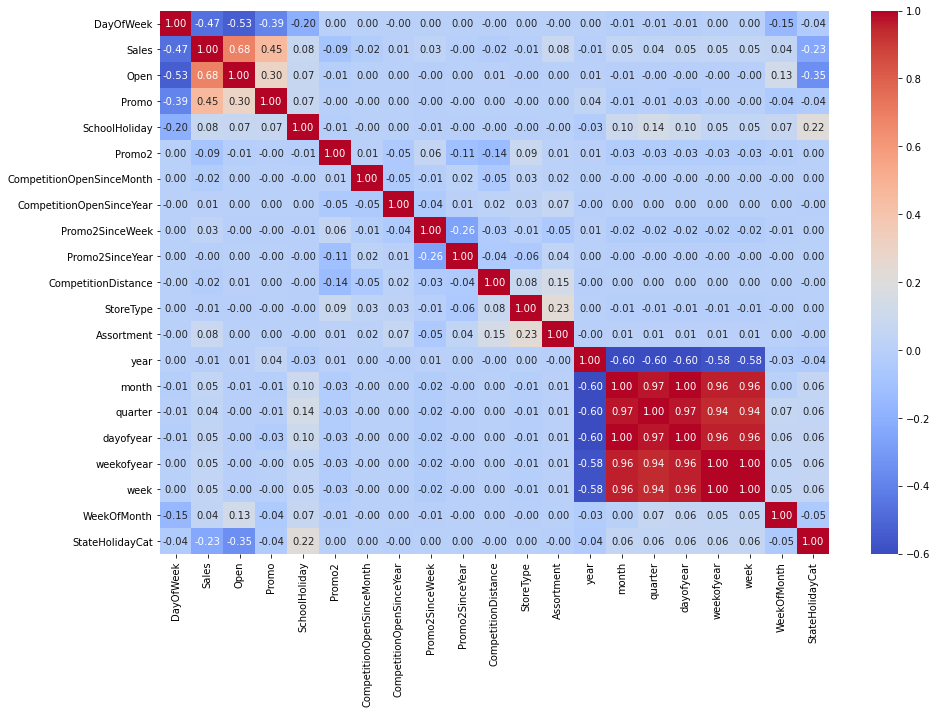

In [34]:
corr_matrix = train_df[corr_attrib].corr()
plt.figure(figsize=(15,10));
sns.heatmap(corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm');

# ❗❗End of Data Setup. Move to Training section ❗❗

In [49]:
data = pd.get_dummies(train_df, columns=['StateHoliday','Assortment'])

In [50]:
data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
712041,1115,7,2013-10-06,0,0,0,0,0,5350.0,NaN,...,0,0,0,0,0,0,1,0,0,1
712042,1115,6,2013-10-05,6460,436,1,0,0,5350.0,NaN,...,0,0,0,0,0,0,1,0,0,1
712043,1115,5,2013-10-04,6107,426,1,0,0,5350.0,NaN,...,0,0,0,0,0,0,1,0,0,1
712044,1115,4,2013-10-03,0,0,0,0,0,5350.0,NaN,...,1,0,0,0,0,0,1,0,0,1
712045,1115,3,2013-10-02,4369,347,1,0,0,5350.0,NaN,...,0,0,0,0,0,0,1,0,0,1


In [52]:
data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'quarter',
       'dayofweek', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'StateHoliday_0',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

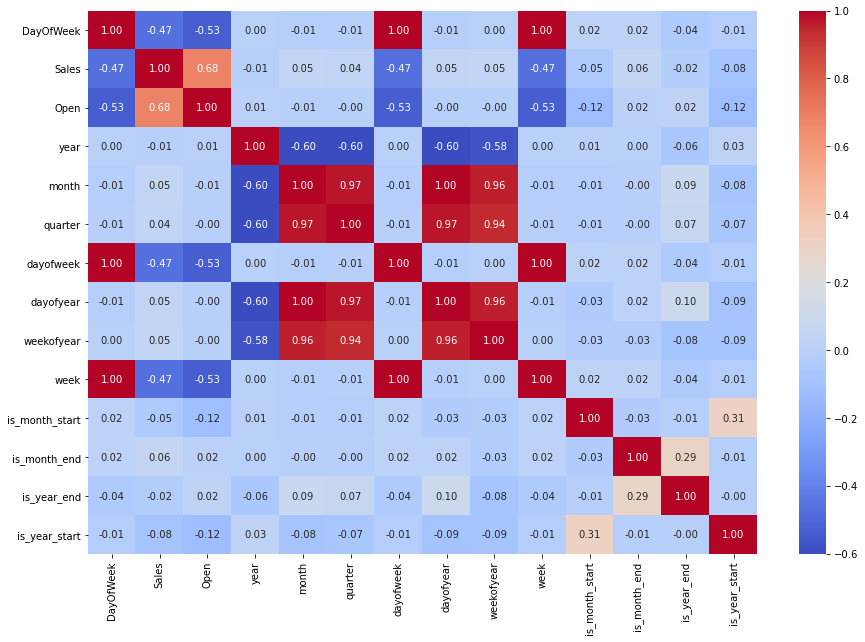

In [56]:
# Correlation Matrix

attributes = ["DayOfWeek", "Sales", "Open", "year", "month",
              "quarter", "dayofweek", "dayofyear",
              "weekofyear", "week", "is_month_start",
              "is_month_end", "is_year_end", "is_year_start"]
corr_matrix = data[attributes].corr()
plt.figure(figsize=(15,10));
sns.heatmap(corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm');


<AxesSubplot:xlabel='Open'>

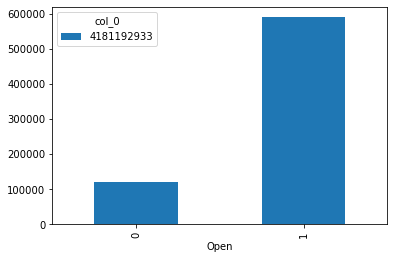

In [19]:
pd.crosstab(train_df['Open'],train_df['Sales'].sum()).plot(kind='bar')

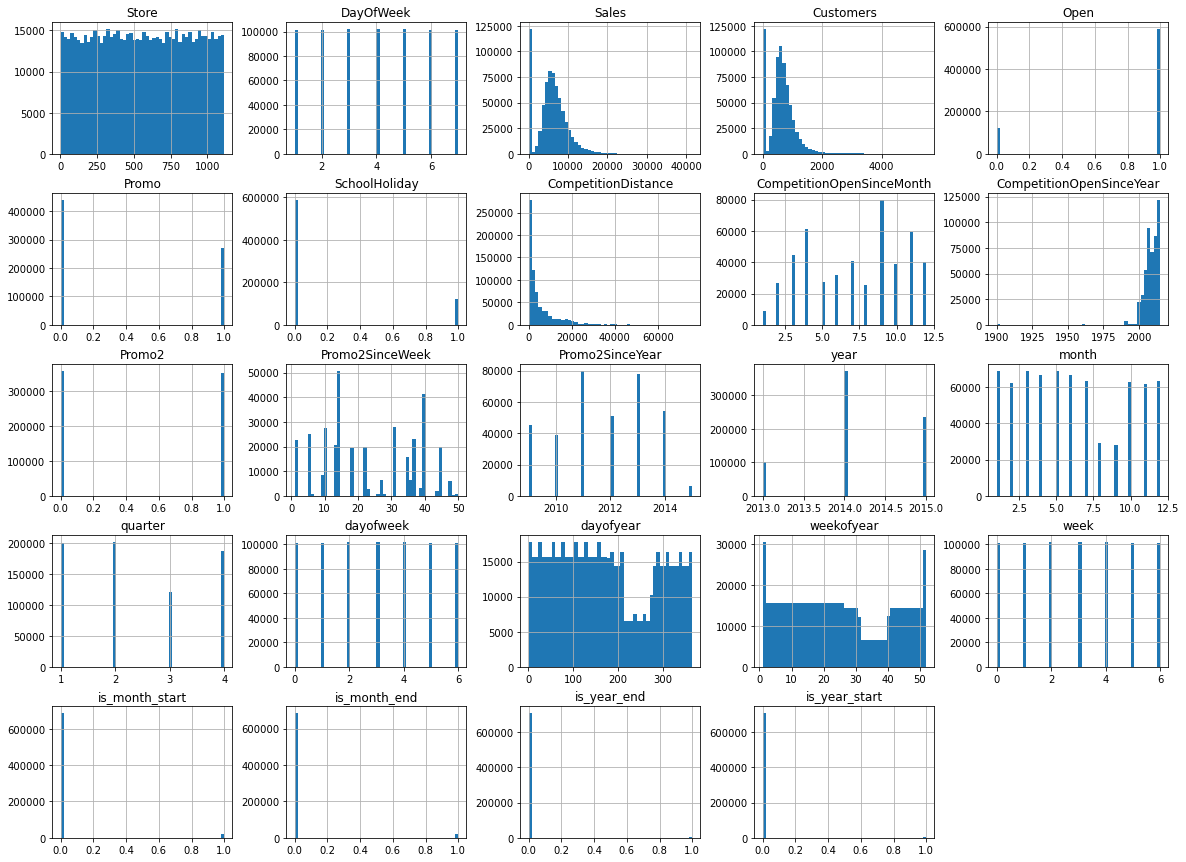

In [64]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

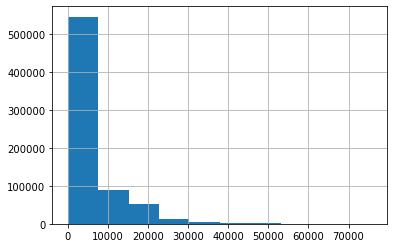

In [65]:
train_df['CompetitionDistance'].hist()

In [69]:
train_df['CompetitionDistance'].isna().value_counts()

False    710225
True       1821
Name: CompetitionDistance, dtype: int64

In [84]:
x = train_df['Sales'].sum()

In [85]:
print(x)

4181192933


In [90]:
train_df['Sales'].describe()

count    712046.000000
mean       5872.082608
std        3918.569033
min           0.000000
25%        3795.000000
50%        5848.000000
75%        7991.000000
max       41551.000000
Name: Sales, dtype: float64

In [88]:
101811/x

2.4349749373308815e-05

In [89]:
pd.crosstab(train_df['year'], (train_df['Sales'].sum()/x))

col_0,1.0
year,
2013,101811
2014,373855
2015,236380


In [97]:
train_df.groupby(["DayOfWeek"]).count()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,month,quarter,dayofweek,dayofyear,weekofyear,week,is_month_start,is_month_end,is_year_end,is_year_start
DayOfWeek,,,,,,,,,,,,,,,,,,,,,
1,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245,...,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245
2,101411,101411,101411,101411,101411,101411,101411,101411,101411,101411,...,101411,101411,101411,101411,101411,101411,101411,101411,101411,101411
3,102180,102180,102180,102180,102180,102180,102180,102180,102180,102180,...,102180,102180,102180,102180,102180,102180,102180,102180,102180,102180
4,102360,102360,102360,102360,102360,102360,102360,102360,102360,102360,...,102360,102360,102360,102360,102360,102360,102360,102360,102360,102360
5,102360,102360,102360,102360,102360,102360,102360,102360,102360,102360,...,102360,102360,102360,102360,102360,102360,102360,102360,102360,102360
6,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245,...,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245
7,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245,...,101245,101245,101245,101245,101245,101245,101245,101245,101245,101245


In [99]:
train_df.shape

(712046, 29)

In [123]:
df1 = train_df[train_df.DayOfWeek == 1][:1000]
df2 = train_df[train_df.DayOfWeek == 2][:1000]
df3 = train_df[train_df.DayOfWeek == 3][:1000]
df4 = train_df[train_df.DayOfWeek == 4][:1000]
df5 = train_df[train_df.DayOfWeek == 5][:1000]
df6 = train_df[train_df.DayOfWeek == 6][:1000]
df7 = train_df[train_df.DayOfWeek == 7][:1000]

In [124]:
df1.shape

(1000, 29)

In [125]:
dftest = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

In [126]:
dftest

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,month,quarter,dayofweek,dayofyear,weekofyear,week,is_month_start,is_month_end,is_year_end,is_year_start
0,1,1,2015-07-27,6102,612,1,1,0,1,c,...,7,3,0,208,31,0,0,0,0,0
1,1,1,2015-07-20,4395,526,1,0,0,0,c,...,7,3,0,201,30,0,0,0,0,0
2,1,1,2015-07-13,5054,553,1,1,0,0,c,...,7,3,0,194,29,0,0,0,0,0
3,1,1,2015-07-06,4359,540,1,0,0,0,c,...,7,3,0,187,28,0,0,0,0,0
4,1,1,2015-06-29,5197,541,1,1,0,0,c,...,6,2,0,180,27,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,11,7,2014-09-14,0,0,0,0,0,0,a,...,9,3,6,257,37,6,0,0,0,0
6996,11,7,2014-09-07,0,0,0,0,0,0,a,...,9,3,6,250,36,6,0,0,0,0
6997,11,7,2014-08-31,0,0,0,0,0,0,a,...,8,3,6,243,35,6,0,1,0,0
6998,11,7,2014-08-24,0,0,0,0,0,0,a,...,8,3,6,236,34,6,0,0,0,0


In [133]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'quarter',
       'dayofweek', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start'],
      dtype='object')

In [152]:
cont_cols = ['CompetitionDistance']
cat_cols = ['DayOfWeek', 'Open', 'year', 'month', 'quarter', 'week']

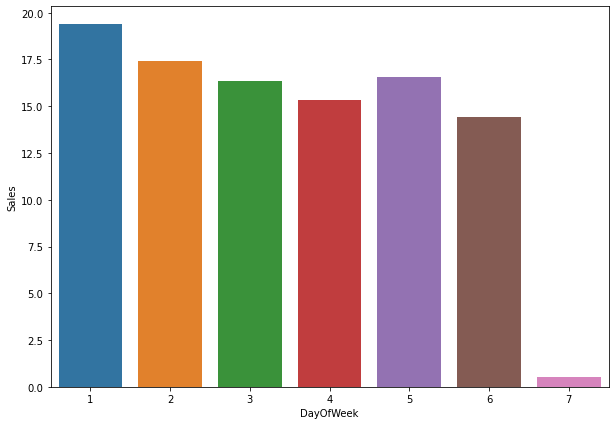

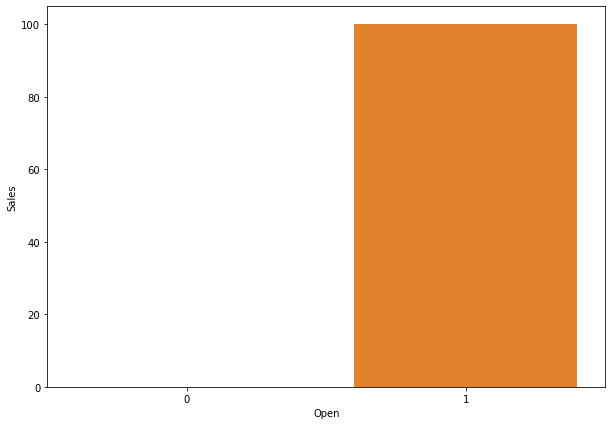

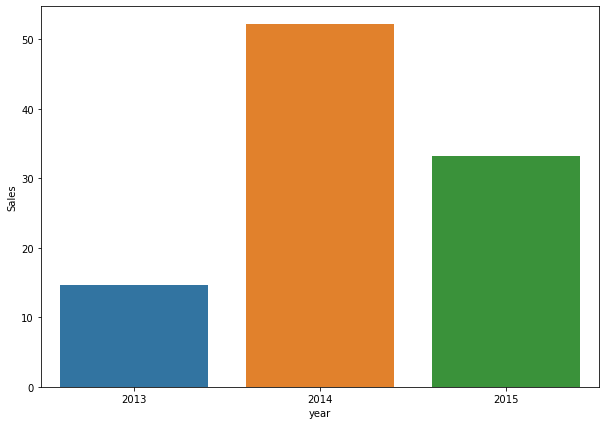

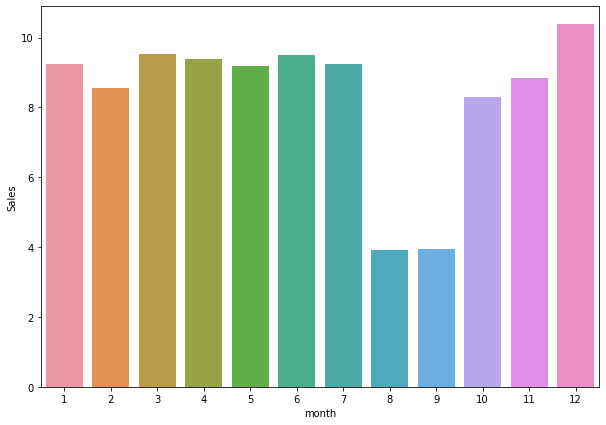

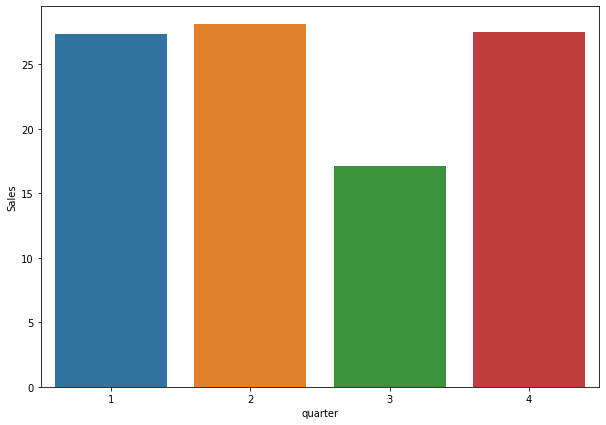

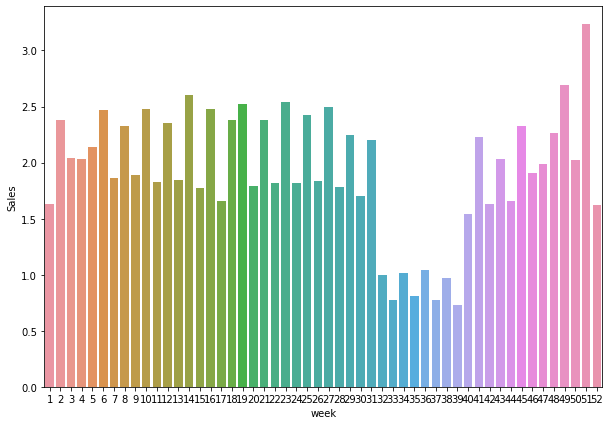

In [153]:
for col in cat_cols:
    plt.figure(figsize=(10,7))
    temp_df = train_df.groupby(col)['Sales'].sum()
    temp_df = temp_df.rename('Sales').reset_index()
    total_sales = temp_df["Sales"].sum()
    temp_df["Sales"] = temp_df["Sales"].apply(lambda x: x/total_sales*100)
    g = sns.barplot(x=col, y='Sales', data=temp_df)

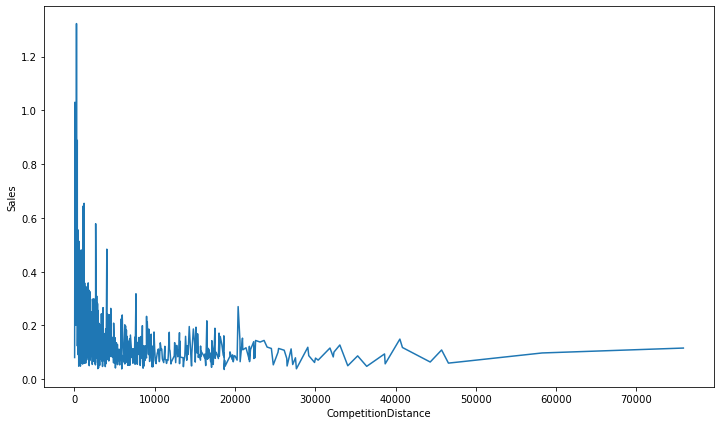

In [147]:
for col in cont_cols:
    plt.figure(figsize=(12,7))
    temp_df = train_df.groupby(col)['Sales'].sum()
    temp_df = temp_df.rename('Sales').reset_index()
    total_sales = temp_df["Sales"].sum()
    temp_df["Sales"] = temp_df["Sales"].apply(lambda x: x/total_sales*100)
    g = sns.lineplot(x=col, y='Sales', data=temp_df)
#     g.ax.set_title(f'{col} distribution with Sales', fontsize=18)
#     g.ax.set_ylabel('Percentage', fontsize=16)
#     g.ax.set_xlabel( f'{col}', fontsize=15)

In [140]:
train_df[train_df.month == 4].count()

Store                        66900
DayOfWeek                    66900
Date                         66900
Sales                        66900
Customers                    66900
Open                         66900
Promo                        66900
StateHoliday                 66900
SchoolHoliday                66900
StoreType                    66900
Assortment                   66900
CompetitionDistance          66720
CompetitionOpenSinceMonth    45660
CompetitionOpenSinceYear     45660
Promo2                       66900
Promo2SinceWeek              34260
Promo2SinceYear              34260
PromoInterval                34260
year                         66900
month                        66900
quarter                      66900
dayofweek                    66900
dayofyear                    66900
weekofyear                   66900
week                         66900
is_month_start               66900
is_month_end                 66900
is_year_end                  66900
is_year_start       

In [145]:
train_df['month'].value_counts()

5     69130
3     69130
1     69130
6     66900
4     66900
12    63550
7     63550
10    62781
2     62440
11    61500
8     28985
9     28050
Name: month, dtype: int64

In [ ]:
train_df[train_df.Assortment == 'a'].sum()
train_df[train_df.Assortment == 'b'].sum()
train_df[train_df.Assortment == 'c'].sum()

## Training Section

In [72]:
X.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Promo2',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDistance',
       'StoreType', 'Assortment', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'year', 'month', 'quarter',
       'dayofyear', 'weekofyear', 'week', 'is_month_start', 'is_month_end',
       'is_year_end', 'is_year_start', 'WeekOfMonth', 'StateHolidayCat'],
      dtype='object')

In [143]:
train_df.drop('Store', axis=1, inplace=True)

In [81]:
# Train-Test Split


X = train_df.drop('Sales', axis=1)
y = train_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
# for i in range(5):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#     print(i)
#     print(len(X_train[X_train.year == 2013]))
#     print(len(X_test[X_test.year == 2013]))
#     en_model = ElasticNet(l1_ratio=0.5, alpha=0.1, random_state=42, warm_start=True)
#     en_model.fit(X_train, y_train)

In [106]:
X = train_df.drop('Sales', axis=1)
y = train_df['Sales']
en_model = ElasticNet(l1_ratio=0.5, alpha=0.1, random_state=42, warm_start=True)
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    print(i)
    print(len(X_train[X_train.year == 2013]))
    print(len(X_test[X_test.year == 2013]))
    en_model.fit(X_train, y_train)

0
81578
20233


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1819628823895.9255, tolerance: 876411394.0857319
  model = cd_fast.enet_coordinate_descent(


1
81433
20378


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1525982357087.255, tolerance: 873853409.6187986
  model = cd_fast.enet_coordinate_descent(


2
81539
20272


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151395034634.9614, tolerance: 875317391.8139973
  model = cd_fast.enet_coordinate_descent(


3
81423
20388


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508844792775.7532, tolerance: 874711729.4244081
  model = cd_fast.enet_coordinate_descent(


4
81279
20532


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2146206547.2607422, tolerance: 874346012.9084334
  model = cd_fast.enet_coordinate_descent(


In [82]:
# ElasticNet

# en_model = ElasticNet(l1_ratio=0.5, alpha=0.1, random_state=42)
# en_model.fit(X_train, y_train)



C:\Users\rishi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503668713889.3616, tolerance: 734309586.3823916
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1, random_state=42)

In [107]:
en_model.score(X_test, y_test)

0.5405568435876429

In [108]:
y_preds = en_model.predict(X_test)

In [109]:
mean_squared_error(y_test, y_preds)

7065768.762184269

In [110]:
type(y_preds)

numpy.ndarray

In [111]:
df_results = pd.DataFrame(y_preds, index = None)
#Remove all negative
df_results[df_results < 0] = 0

In [112]:
df_results.shape

(142410, 1)

In [113]:
y_pred = np.array(df_results)

In [114]:
mean_squared_error(y_test, y_pred)

7064079.645221777

In [115]:
mean_absolute_error(y_test, y_pred)

1885.0428586112885

In [116]:
r2_score(y_test, y_pred)

0.5406666763963459

In [117]:
importance = en_model.coef_

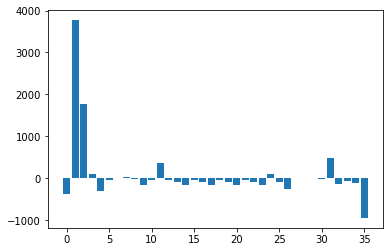

In [127]:
# summarize feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [119]:
X_train.columns

Index(['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Promo2',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDistance',
       'StoreType', 'Assortment', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'year', 'month', 'quarter',
       'dayofyear', 'weekofyear', 'week', 'is_month_start', 'is_month_end',
       'is_year_end', 'is_year_start', 'WeekOfMonth', 'StateHolidayCat'],
      dtype='object')

In [104]:
print(en_model.get_params())

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': True}


In [121]:
imp2 = en_model.sparse_coef_

36 features, reduction of 0.00%


<AxesSubplot:>

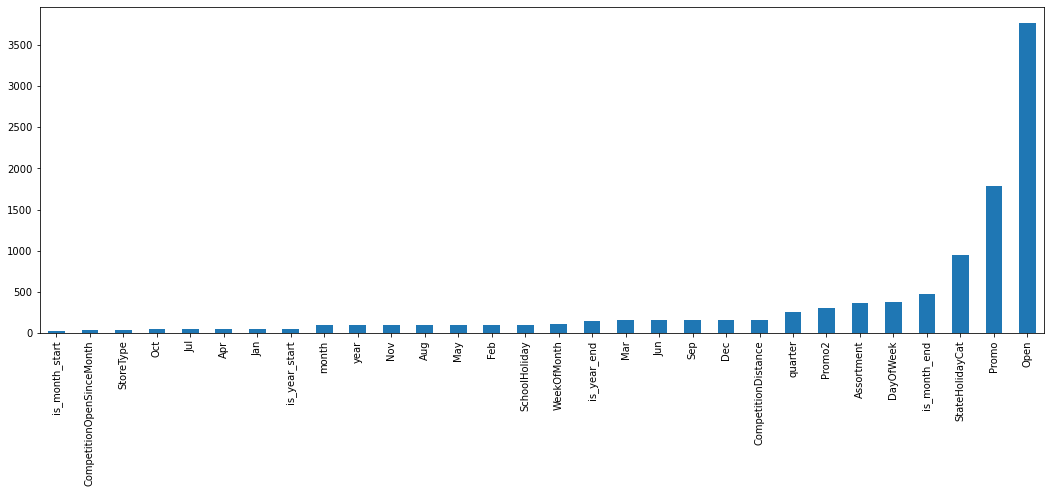

In [128]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(en_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

In [130]:
# Save model
pickle.dump(en_model,open("SalesFirstModel.pkl","wb"))

In [132]:
load_model = pickle.load(open('SalesFirstModel.pkl','rb'))

In [134]:
df = pd.read_csv('dataset/TEST.csv')

In [144]:
train_df.head(3).T

,0,1,2
DayOfWeek,1.000000,3.000000,7.000000
Open,0.000000,1.000000,0.000000
Promo,0.000000,0.000000,0.000000
SchoolHoliday,1.000000,0.000000,0.000000
Promo2,0.000000,0.000000,0.000000
CompetitionOpenSinceMonth,8.000000,8.000000,8.000000
CompetitionOpenSinceYear,2010.000000,2010.000000,2010.000000
Promo2SinceWeek,22.000000,22.000000,22.000000
Promo2SinceYear,2012.000000,2012.000000,2012.000000
CompetitionDistance,1.004222,1.004222,1.004222


In [146]:
results = load_model.predict(train_df)

In [147]:
df_results = pd.DataFrame(results, index = None)
#Remove all negative
df_results[df_results < 0] = 0
df_results["Index"]=range(0, len(df_results))
df_results.columns=["Sales","Index"]

columns_titles = ["Index","Sales"]
df_results=df_results.reindex(columns=columns_titles)
#Apply Up on the Sales column
df_results['Sales'] = df_results['Sales'].apply(np.ceil)
print(df_results.info())
print(df_results.head())
df_results.to_csv("output.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305163 entries, 0 to 305162
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Index   305163 non-null  int32  
 1   Sales   305163 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None
   Index   Sales
0      0  1662.0
1      1  6812.0
2      2  1258.0
3      3  5564.0
4      4  1971.0
